In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%run ../src/cot/train.py

INFO:root:Parsing arguments.
INFO:cot.data.data_processing:Generating data. Saving in /private/home/vivc/code/llm/cot/data/raw/binary_copy
INFO:cot.data.data_processing:Loading training data for binary_copy problem.
INFO:cot.data.data_processing:Setting sampler.
INFO:cot.data.data_processing:Loading test data for binary_copy problem.
INFO:__main__:Number of training data: 382.
INFO:__main__:Model: Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(5, 128)
    (pos_emb): Embedding(19, 128)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2

In [17]:
import matplotlib.pyplot as plt
import torch
from cot.data import BinaryCopy, Parity
from cot.config import CHECKPOINT_DIR

problem = BinaryCopy

path = CHECKPOINT_DIR / problem.prefix / 'model.pth'

checkpoint = torch.load(path)

evals = checkpoint["evals"]
ind = evals != -1
evals = evals[ind]

eval = checkpoint["evals"].argmax() + 1

acc_by_len = checkpoint["acc_by_len"][ind]
test_acc_by_len = checkpoint["test_acc_by_len"][ind]
spe_acc = checkpoint["spe_acc"][ind]
test_spe_acc = checkpoint["test_spe_acc"][ind]
losses = checkpoint["losses"][ind]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 21

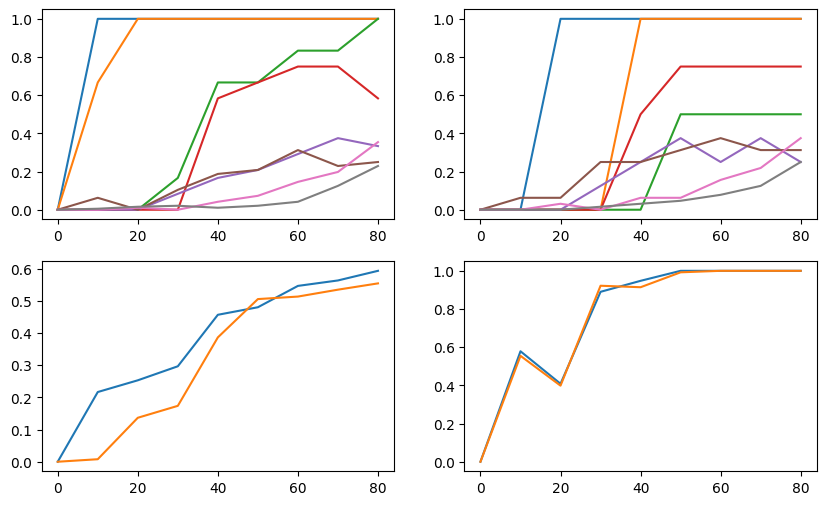

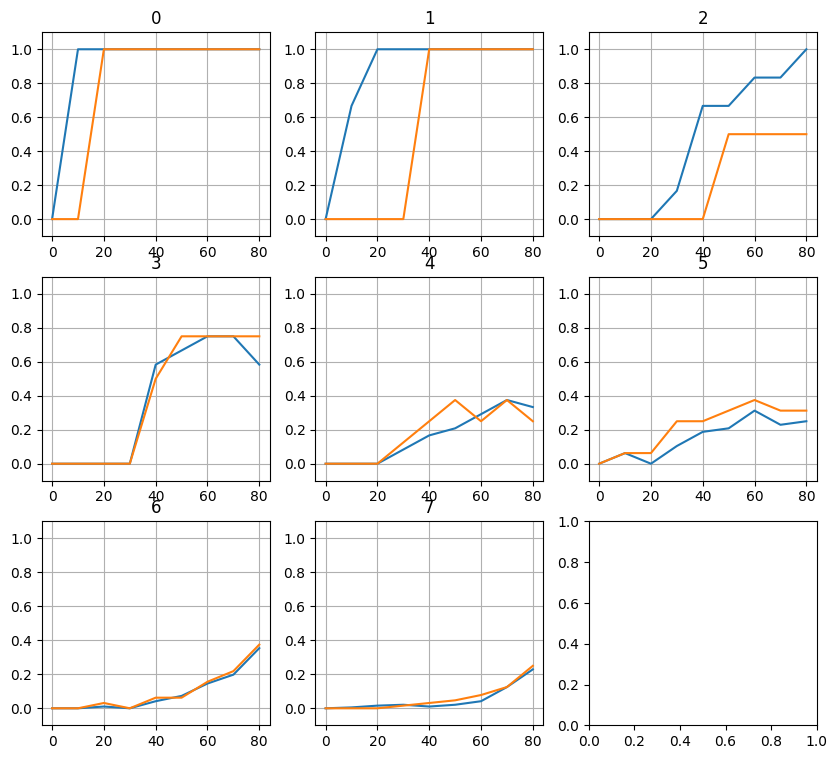

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].plot(evals, acc_by_len)
axes[0, 1].plot(evals, test_acc_by_len)
axes[1, 0].plot(evals, acc_by_len.mean(axis=1))
axes[1, 0].plot(evals, test_acc_by_len.mean(axis=1))
axes[1, 1].plot(evals, spe_acc[:, 2])
axes[1, 1].plot(evals, test_spe_acc[:, 2])
# axes[1, 1].set_xlim(0, 50)

nb_len = 8
fig, axes = plt.subplots(nb_len // 3 + (1 if nb_len % 3 else 0), 3, figsize=(10, 9))
for i in range(nb_len):
    axes[i // 3, i % 3].plot(evals, acc_by_len[:, i])
    axes[i // 3, i % 3].plot(evals, test_acc_by_len[:, i])
    axes[i // 3, i % 3].set_ylim(-.1, 1.1)
    axes[i // 3, i % 3].set_title(i)
    axes[i // 3, i % 3].grid()

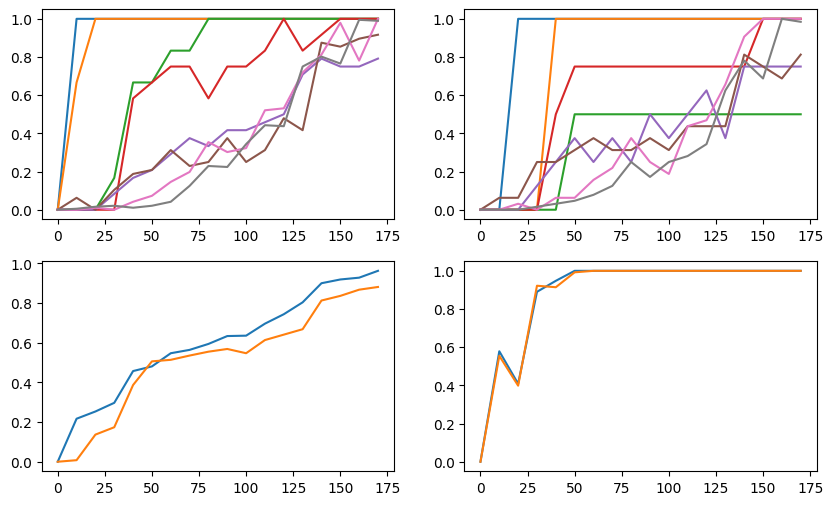

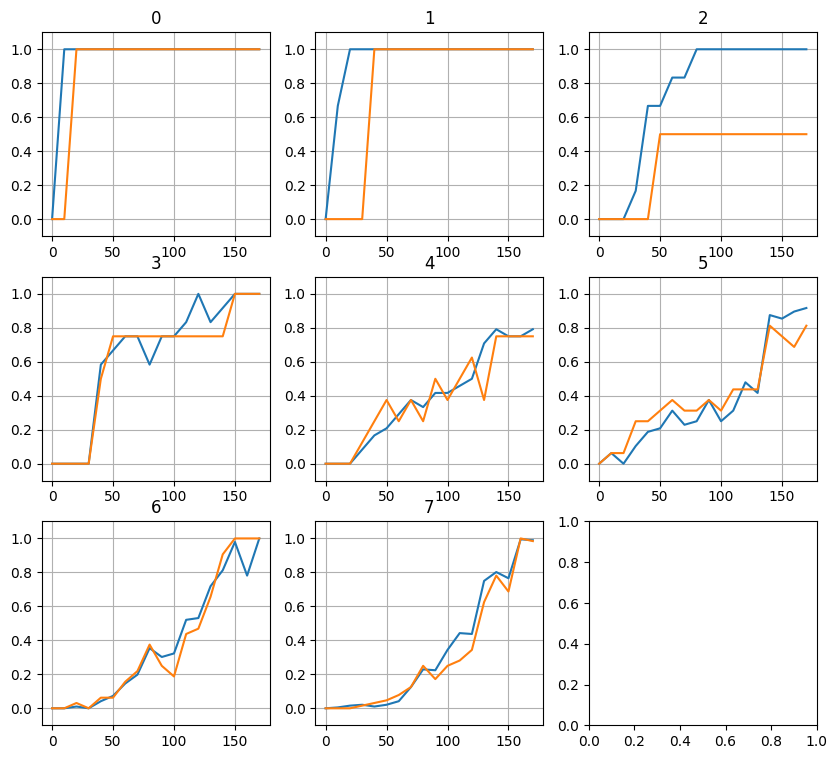

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].plot(evals, acc_by_len)
axes[0, 1].plot(evals, test_acc_by_len)
axes[1, 0].plot(evals, acc_by_len.mean(axis=1))
axes[1, 0].plot(evals, test_acc_by_len.mean(axis=1))
axes[1, 1].plot(evals, spe_acc[:, 2])
axes[1, 1].plot(evals, test_spe_acc[:, 2])
# axes[1, 1].set_xlim(0, 50)

nb_len = 8
fig, axes = plt.subplots(nb_len // 3 + (1 if nb_len % 3 else 0), 3, figsize=(10, 9))
for i in range(nb_len):
    axes[i // 3, i % 3].plot(evals, acc_by_len[:, i])
    axes[i // 3, i % 3].plot(evals, test_acc_by_len[:, i])
    axes[i // 3, i % 3].set_ylim(-.1, 1.1)
    axes[i // 3, i % 3].set_title(i)
    axes[i // 3, i % 3].grid()